<a href="https://colab.research.google.com/github/DeeeTeeee/TensorFlowDeveloperCert/blob/main/Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using more sophisticated images with Convolutional Neural Networks
David Anifowoshe

First reviewing how to build CNNs then, prepare data with `ImageDataGenerator` and examine the results. we'll follow these steps:

Explore the example data of Dogs vs. Cats

Build and train a neural network to classify between the two pets

Evaluate the training and validation accuracy


downloading the dataset. This is a .zip of 2,000 JPG pictures of cats and dogs. It is a subset of the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. I only use 2,000 of the full dataset to decrease training time.

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-11-21 10:12:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 173.194.195.207, 173.194.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   159MB/s    in 0.4s    

2023-11-21 10:12:31 (159 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
import zipfile

# Unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [3]:
import os

base_dir = 'cats_and_dogs_filtered'

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['validation', 'train', 'vectorize.py']

Contents of train directory:
['cats', 'dogs']

Contents of validation directory:
['cats', 'dogs']


let's assign each of these directories to a variable so we can use it later.

In [4]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

if you are running this notebook with me, you can at this point see what the filenames look like in the cats and dogs train directories (file naming conventions are the same in the validation directory):

check your directory, you will find them there

lets view them here:

In [7]:
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

print(train_cat_fnames[:20])
print(train_dog_fnames[:20])

['cat.306.jpg', 'cat.365.jpg', 'cat.817.jpg', 'cat.687.jpg', 'cat.807.jpg', 'cat.521.jpg', 'cat.354.jpg', 'cat.163.jpg', 'cat.261.jpg', 'cat.311.jpg', 'cat.660.jpg', 'cat.10.jpg', 'cat.344.jpg', 'cat.942.jpg', 'cat.651.jpg', 'cat.546.jpg', 'cat.472.jpg', 'cat.745.jpg', 'cat.26.jpg', 'cat.169.jpg']
['dog.290.jpg', 'dog.69.jpg', 'dog.242.jpg', 'dog.793.jpg', 'dog.304.jpg', 'dog.556.jpg', 'dog.147.jpg', 'dog.545.jpg', 'dog.21.jpg', 'dog.282.jpg', 'dog.983.jpg', 'dog.969.jpg', 'dog.650.jpg', 'dog.661.jpg', 'dog.209.jpg', 'dog.579.jpg', 'dog.603.jpg', 'dog.846.jpg', 'dog.87.jpg', 'dog.80.jpg']


Let's find out the total number of cat and dog images in the train and validation directories:

In [9]:
#Let's find out the total number of cat and dog images in the train and validation directories:
print('total training cat images :', len(os.listdir(train_cats_dir ) ))
print('total training dog images :', len(os.listdir(train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500


Let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like.

configuring the matplotlib parameters:

In [10]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

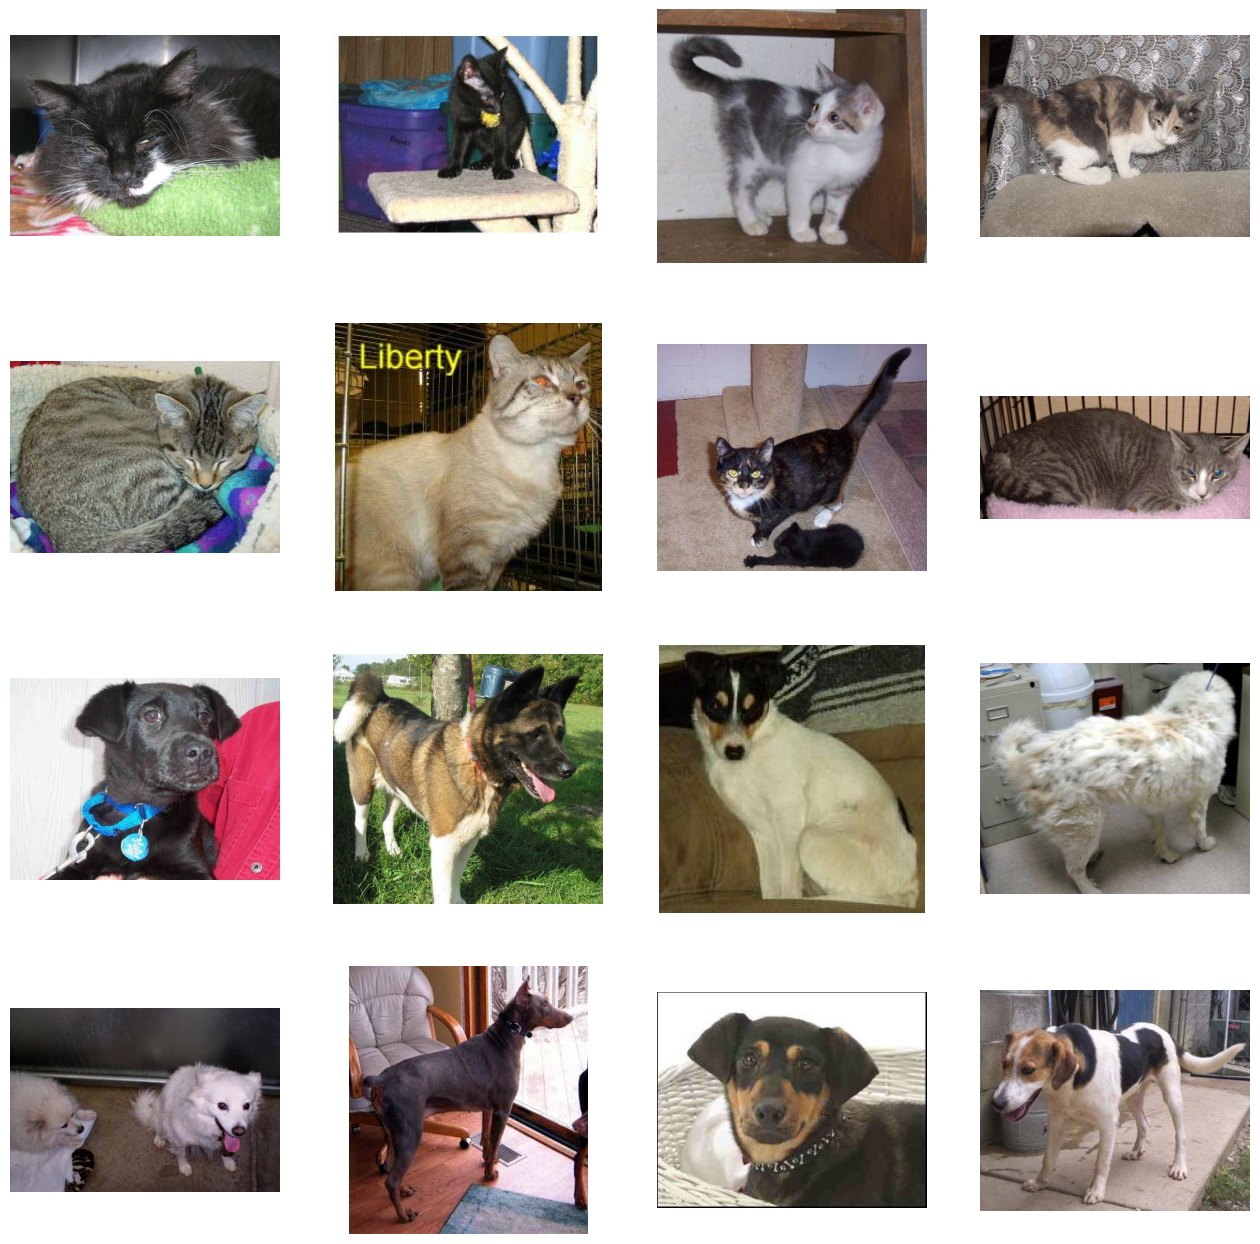

In [16]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index-8:pic_index]
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Building a Small Model from Scratch to get to ~72% Accuracy

To train a neural network to handle the images, I'll need them to be in a uniform size. I will choose 150x150 pixels for this, and you'll see the code that preprocesses the images to that shape shortly.

I can define the model by importing Tensorflow and using the Keras API. Here is the entire code first, then the explanation.

In [18]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 64)       

In [22]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['acc'])

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


##Training

I will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch.

4 values per epoch -- Loss, Accuracy, Validation Loss and Validation Accuracy.

In [24]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

Epoch 1/15
100/100 - 67s - loss: 0.7116 - acc: 0.5290 - val_loss: 0.6650 - val_acc: 0.5900 - 67s/epoch - 675ms/step
Epoch 2/15
100/100 - 66s - loss: 0.6288 - acc: 0.6450 - val_loss: 0.6262 - val_acc: 0.6420 - 66s/epoch - 660ms/step
Epoch 3/15
100/100 - 67s - loss: 0.5864 - acc: 0.6985 - val_loss: 0.5978 - val_acc: 0.6550 - 67s/epoch - 672ms/step
Epoch 4/15
100/100 - 67s - loss: 0.5431 - acc: 0.7230 - val_loss: 0.5661 - val_acc: 0.7100 - 67s/epoch - 665ms/step
Epoch 5/15
100/100 - 65s - loss: 0.5072 - acc: 0.7400 - val_loss: 0.5376 - val_acc: 0.7230 - 65s/epoch - 654ms/step
Epoch 6/15
100/100 - 64s - loss: 0.4495 - acc: 0.7840 - val_loss: 0.6071 - val_acc: 0.6800 - 64s/epoch - 639ms/step
Epoch 7/15
100/100 - 66s - loss: 0.4081 - acc: 0.8050 - val_loss: 0.6306 - val_acc: 0.7120 - 66s/epoch - 664ms/step
Epoch 8/15
100/100 - 68s - loss: 0.3383 - acc: 0.8470 - val_loss: 0.6145 - val_acc: 0.7220 - 68s/epoch - 679ms/step
Epoch 9/15
100/100 - 68s - loss: 0.2697 - acc: 0.8860 - val_loss: 0.7016

## Model Prediction

In [25]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving d1.jpeg to d1.jpeg
Saving d2.jpeg to d2.jpeg
Saving d3.jpeg to d3.jpeg
Saving d4.jpeg to d4.jpeg
Saving d5.jpeg to d5.jpeg
Saving download (1).jpeg to download (1).jpeg
Saving download (2).jpeg to download (2).jpeg
Saving download (3).jpeg to download (3).jpeg
Saving download.jpeg to download.jpeg
Saving images.jpeg to images.jpeg
1/1 [==============================] - 0s 124ms/step
[2.8847147e-10]
d1.jpeg is a cat
1/1 [==============================] - 0s 32ms/step
[0.12978165]
d2.jpeg is a cat
1/1 [==============================] - 0s 31ms/step
[0.03933941]
d3.jpeg is a cat
1/1 [==============================] - 0s 31ms/step
[0.09394331]
d4.jpeg is a cat
1/1 [==============================] - 0s 30ms/step
[0.04157689]
d5.jpeg is a cat
1/1 [==============================] - 0s 30ms/step
[1.]
download (1).jpeg is a dog
1/1 [==============================] - 0s 31ms/step
[0.98867065]
download (2).jpeg is a dog
1/1 [==============================] - 0s 31ms/step
[0.82250774]
downl

It predicted all correct 100% right,

I will try more complex pics:


In [26]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():

  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)

  print(classes[0])

  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving e1.jpeg to e1.jpeg
Saving e2.jpeg to e2.jpeg
Saving e3.jpeg to e3.jpeg
Saving e4.jpeg to e4.jpeg
Saving e5.jpeg to e5.jpeg
Saving images (1).jpeg to images (1).jpeg
Saving images (2).jpeg to images (2).jpeg
Saving images (3).jpeg to images (3).jpeg
Saving images (4).jpeg to images (4).jpeg
Saving images.jpeg to images (5).jpeg
1/1 [==============================] - 0s 55ms/step
[0.99999917]
e1.jpeg is a dog
1/1 [==============================] - 0s 52ms/step
[0.0054897]
e2.jpeg is a cat
1/1 [==============================] - 0s 49ms/step
[0.9460288]
e3.jpeg is a dog
1/1 [==============================] - 0s 55ms/step
[0.9998382]
e4.jpeg is a dog
1/1 [==============================] - 0s 69ms/step
[0.02207467]
e5.jpeg is a cat
1/1 [==============================] - 0s 49ms/step
[0.9996005]
images (1).jpeg is a dog
1/1 [==============================] - 0s 71ms/step
[0.99998]
images (2).jpeg is a dog
1/1 [==============================] - 0s 46ms/step
[0.7200621]
images (3).jpeg i

70% right this round.

Actually the

e1 is a cat laughing with its teeth out

e3 there are two cats on this pic, one looking at a lighted cat-balloon nd the other with its tongue out

e4 a cat dressed sitting on a reading table reading with glasses in it.

the CNN has really tried getting all the dogs right cause there are very consufing pics in there.

### let me display the images below



New Cat Images:


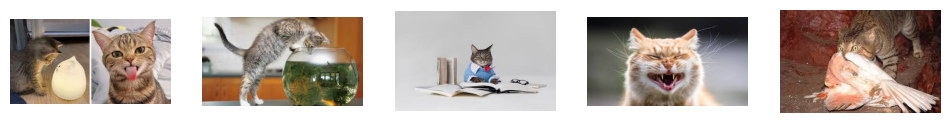

New Dog Images:


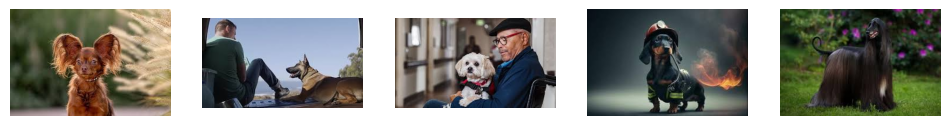

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Replace these paths with the directory paths where your new cat and dog images are stored
new_cats_dir = "/content/new_cats"
new_dogs_dir = "/content/new_dogs"

# Function to display images from a directory
def display_images(directory):
    plt.figure(figsize=(12, 12))
    for i, file in enumerate(os.listdir(directory)[:10]):
        img_path = os.path.join(directory, file)
        plt.subplot(2, 5, i + 1)
        plt.imshow(mpimg.imread(img_path))
        plt.axis('off')
    plt.show()

# Display new cat images
print("New Cat Images:")
display_images(new_cats_dir)

# Display new dog images
print("New Dog Images:")
display_images(new_dogs_dir)


## Visualizing Intermediate Representations

this is how it trains

1/1 [==============================] - 0s 99ms/step


<ipython-input-38-1a9fa0e01e94>:48: RuntimeWarning: invalid value encountered in divide
  x /= x.std ()


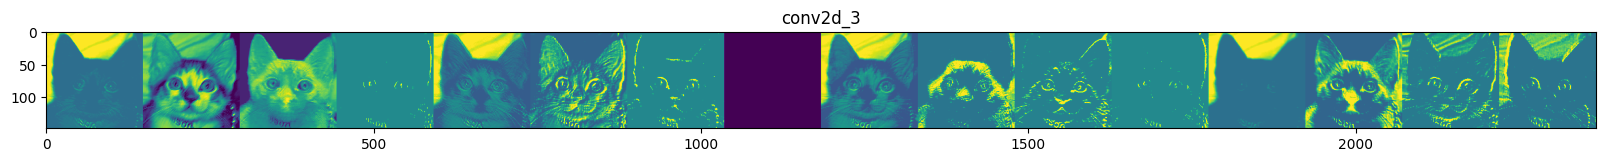

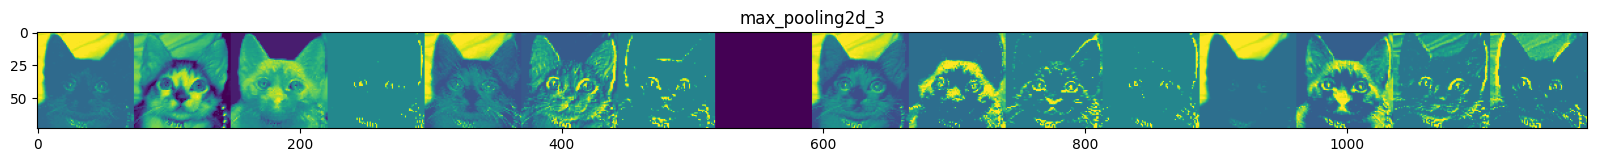

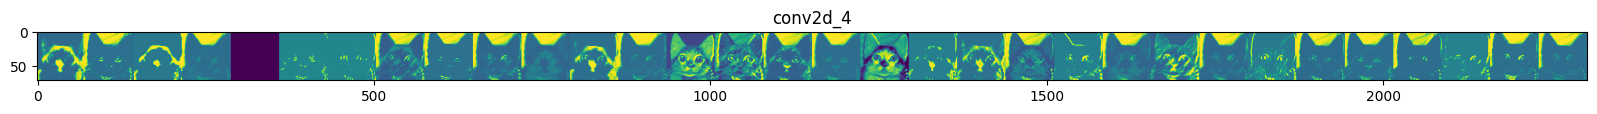

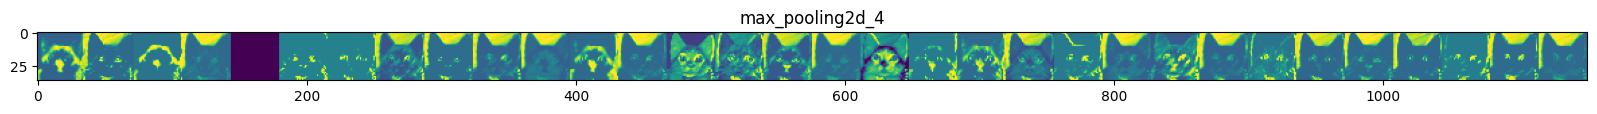

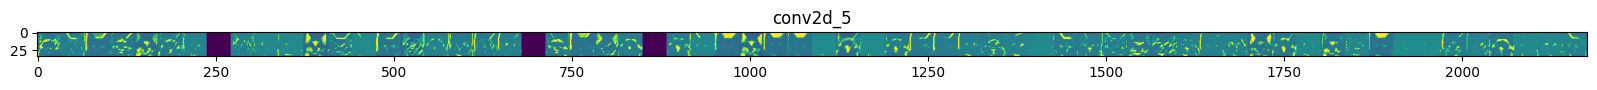

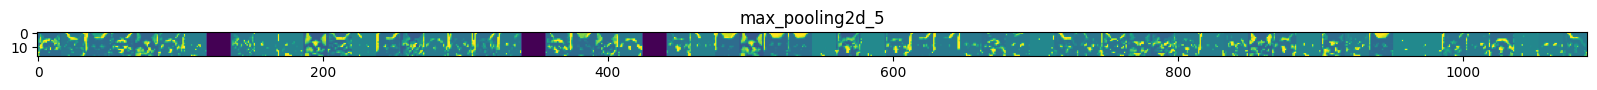

In [38]:
import numpy as np
import random
from tensorflow.keras.utils import img_to_array, load_img

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Scale by 1/255
x /= 255.0

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))

    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )

##Evaluating Accuracy and Loss for the Model

Lets plot the training/validation accuracy and loss as collected during training:

Text(0.5, 1.0, 'Training and validation loss')

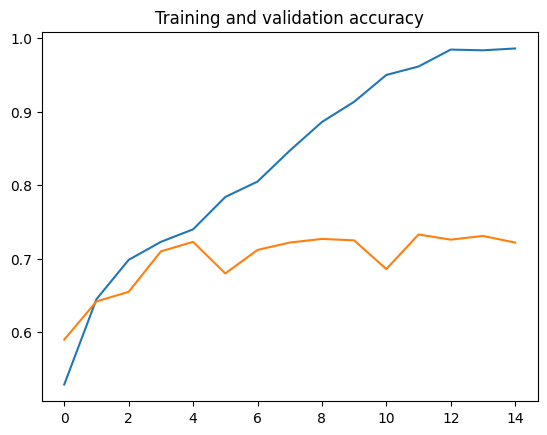

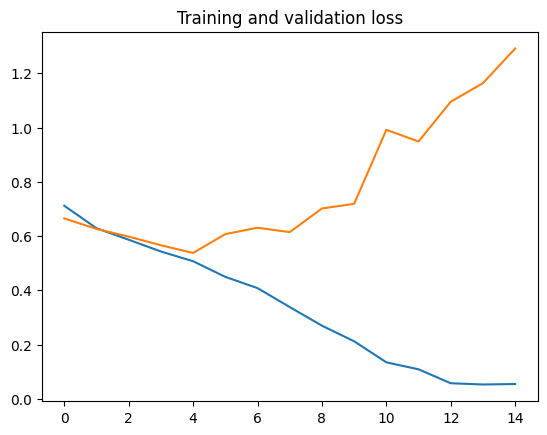

In [33]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['acc']
val_acc  = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )